## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [359]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Clear the data 

After running this part of the code, we can work with the data from file: ```WISDM_ar_v1.1_raw_cleared.txt```.

In [58]:
f_read = open("../data/WISDM/WISDM_ar_v1.1_raw.txt", "r")
f_write = open("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", "w")
for string in f_read.readlines():
    if string[-1] == '\n':
        string = string[:-1]
    if len(string) > 0:
        string_list = string.split(';')
        if len(string_list) > 2:
            for row in string_list[:2]:
                words = row.split(',')
                if len(words) > 5:
                    if len(words[5]) > 0:
                        f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                               words[2], words[3], 
                                                               words[4], words[5]))
        else:
            words = string_list[0].split(',')
            if len(words) > 5:
                if len(words[5]) > 0:
                    f_write.write("%s,%s,%s,%s,%s,%s\n" % (words[0], words[1], 
                                                           words[2], words[3], 
                                                           words[4], words[5]))
f_read.close()
f_write.close()

## Read data

Read the data to pandas:  
* ```id_user``` - identification number of the user (from 1 to 36 inclusively);
* ```activity``` - type of activity (our classes: ```['Downstairs', 'Sitting', 'Walking', 'Upstairs', 'Jogging', 'Standing']```);
* ```timestamp``` - time of measurement (in nanoseconds);
* ```x``` - acceleration in $x$ direction;
* ```y``` - acceleration in $y$ direction;
* ```z``` - acceleration in $z$ direction;

In [59]:
data = pd.read_table("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", delimiter=',', header=None)
data.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']
data.head()

,id_user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


Class distribution:

In [113]:
classes = list(set(data['activity']))
for activity in classes:
    nb = np.sum(data['activity'] == activity)
    print("{:<15}{:<9d}{:<5.2f} %".format(activity, nb, 100. * nb / data.shape[0]))
print()
print("Number of objects: {:d}".format(data.shape[0]))

Downstairs     100427   9.14  %
Sitting        59939    5.46  %
Walking        424399   38.64 %
Upstairs       122869   11.19 %
Jogging        342179   31.16 %
Standing       48395    4.41  %

Number of objects: 1098208


Example of the data:

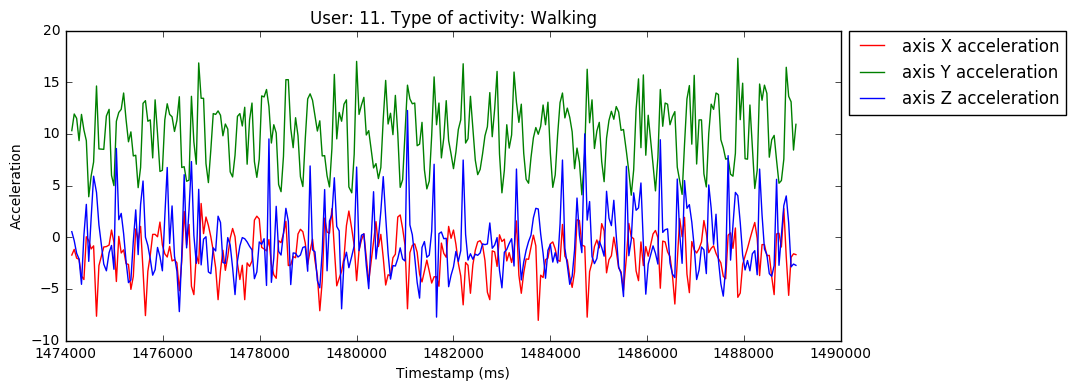

In [304]:
id_user, activity = 11, 'Walking'

mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
x = np.array(data.loc[mask, 'timestamp'])[:np.min([300, np.sum(mask)])] / 10**6
yx = np.array(data.loc[mask, 'x'])[:np.min([300, np.sum(mask)])]
yy = np.array(data.loc[mask, 'y'])[:np.min([300, np.sum(mask)])]
yz = np.array(data.loc[mask, 'z'])[:np.min([300, np.sum(mask)])]

if np.sum(mask) > 0:
    plt.figure(figsize=(10, 4))
    plt.plot(x, yx, 'r', label='axis X acceleration')
    plt.plot(x, yy, 'g', label='axis Y acceleration')
    plt.plot(x, yz, 'b', label='axis Z acceleration')
    plt.xlabel('Timestamp (ms)')
    plt.ylabel('Acceleration')
    plt.title("User: {}. Type of activity: {}".format(id_user, activity))
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.show()
else:
    print("There is no such data.")

## Base method

The idea is the following: we will consider 10 seconds time series (or 200 points of measurements) and calculate 40 features:
* ```[3]``` - mean acceleration of each axis;
* ```[3]``` - std of acceleration of each axis;
* ```[3]``` - mean absolute deviation of acceleration of each axis;
* ```[1]``` - mean acceleration;
* ```[30]``` - distribution of time series values of each axis. First of all we calculate min and max of each component ($X, Y, Z$) from the whole interval. Then we divide the range of values of each component into 10 equal intervals and calculate on each each interval the percent of values that are in it (in the corresponding interval).  

And apply LogisticRegression and SVM.

### Creating object-feature matrix

So we need to construct 10 seconds time series. To do it we need to remember the following:
* each time series should be from one user and one type of activity;
* in the time series timestamp should't differ more then 0.2 second (empirical rule, in ideal all timestamp should differ on 50 ms = 0.05 second).

Now let's create **object-feature** matrix:

In [316]:
def check_candidat(candidat, threshold=2.*1e8):
    tsp = np.array(candidat['timestamp'])
    diffs = tsp[1:] - tsp[:-1]
    
    return np.sum(diffs > threshold) == 0

def get_time_series(accelerations, nb=200):
    accelerations.index = [i for i in range(len(accelerations))]
    TS = []
    st = 0
    fi = st + nb
    while fi < len(accelerations):
        candidat = accelerations.loc[[st + i for i in range(nb)], :]
        if check_candidat(candidat):
            TS.append([np.array(candidat['x']), 
                       np.array(candidat['y']), 
                       np.array(candidat['z'])])
        st = fi
        fi += nb
    
    return TS

def get_features(ts):
    x = ts[0]
    y = ts[1]
    z = ts[2]
    n = x.shape[0]
    features = []
    features.append(x.mean())
    features.append(y.mean())
    features.append(z.mean())
    features.append(x.std())
    features.append(y.std())
    features.append(z.std())
    features.append(np.abs(x - x.mean()).mean())
    features.append(np.abs(y - y.mean()).mean())
    features.append(np.abs(z - z.mean()).mean())
    features.append((x+y+z).mean() / 3.)
    x_range = np.linspace(x.min(), x.max(), 11)
    y_range = np.linspace(y.min(), y.max(), 11)
    z_range = np.linspace(z.min(), z.max(), 11)
    for i in range(10):
        features.append(1. * np.sum((x_range[i] <= x) & (x < x_range[i+1])) / n)
        features.append(1. * np.sum((y_range[i] <= y) & (y < y_range[i+1])) / n)
        features.append(1. * np.sum((z_range[i] <= z) & (z < z_range[i+1])) / n)
    
    return features

In [317]:
columns = ['avg_x', 'avg_y', 'avg_z', 
           'std_x', 'std_y', 'std_z', 
           'abs_x', 'abs_y', 'abs_z', 'mean']
for i in range(10):
    name = str(i) + '_'
    columns += [name + 'x', name + 'y', name + 'z']
df = pd.DataFrame(columns=['activity']+columns) 

id_range = np.unique(np.array(data['id_user']))
for id_user in id_range:
    for activity in classes:
        mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
        accelerations = data.loc[mask, ['timestamp', 'x', 'y', 'z']].copy()
        TS = get_time_series(accelerations, nb=200)
        for ts in TS:
            features = get_features(ts)
            df.loc[len(df), :] = [classes.index(activity)] + features
df.head(5)

,activity,avg_x,avg_y,avg_z,std_x,std_y,std_z,abs_x,abs_y,abs_z,...,6_z,7_x,7_y,7_z,8_x,8_y,8_z,9_x,9_y,9_z
0,0,-4.3975,8.9068,1.38965,5.06765,4.73418,4.36999,3.98163,3.9227,3.40262,...,0.055,0.08,0.095,0.04,0.065,0.06,0.025,0.005,0.035,0.005
1,0,-8.7679,5.6245,0.9339,5.12277,5.06104,3.65605,4.09866,4.20284,2.75806,...,0.085,0.04,0.09,0.045,0.02,0.03,0.02,0.005,0.035,0.01
2,0,-9.1133,5.5684,0.88,4.97095,4.62019,3.74343,3.82394,3.80721,2.7964,...,0.045,0.045,0.065,0.055,0.02,0.045,0.02,0.03,0.02,0.015
3,0,-5.20155,9.26205,0.70115,5.73362,4.07532,3.91184,4.57432,3.2371,2.91443,...,0.065,0.065,0.06,0.03,0.075,0.05,0.025,0.02,0.035,0
4,0,-7.0836,7.8197,0.61605,5.86019,3.9993,3.97511,4.59415,3.05909,2.89976,...,0.035,0.065,0.065,0.02,0.02,0.03,0.03,0.015,0.025,0.005


Class distribution:

In [318]:
for activity in classes:
    nb = np.sum(df['activity'] == classes.index(activity))
    print("{:<15}{:<9d}{:<5.2f} %".format(activity, nb, 100. * nb / df.shape[0]))
print()
print("Number of objects: {:d}".format(df.shape[0]))

Downstairs     357      8.26  %
Sitting        277      6.41  %
Walking        1917     44.36 %
Upstairs       466      10.78 %
Jogging        1075     24.88 %
Standing       229      5.30  %

Number of objects: 4321


In [342]:
X = df[columns].values
y = df['activity'].values

### Classification

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Let's try LogisticRegression:

In [374]:
def get_internal_score(clf, X, y, max_iter=50):
    nb = np.unique(y).shape[0]
    scores = np.zeros(nb+1)
    for j in range(max_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        scores[0] += accuracy_score(y_test, y_predict)
        for i in range(nb):
            scores[i+1] += accuracy_score(1*(np.array(y_test) == i), 
                                         1*(np.array(y_predict) == i))
            
    return scores / max_iter

In [376]:
parameters = {'penalty': ['l1', 'l2'], 
              'class_weight': ['balanced', None], 
              'C': 10. ** np.arange(0, 5, 1)}
clf = LogisticRegression()
clf = GridSearchCV(clf, parameters)
clf.fit(X_train, list(y_train))
clf_lr = clf.best_estimator_
scores = get_internal_score(clf_lr, X, list(y))

In [394]:
print("{:<20}{:<7}{:<11}{:<11}{:<11}{:<11}{:<11}{:<11}".format("", "all", *classes))
print("{:<20}{:<7.3f}{:<11.3f}{:<11.3f}{:<11.3f}{:<11.3f}{:<11.3f}{:<11.3f}".format("LogisticRegression:", *scores))

                    all    Downstairs Sitting    Walking    Upstairs   Jogging    Standing   
LogisticRegression: 0.856  0.941      0.990      0.897      0.909      0.984      0.991      
